# Simulation of a silicon solar cell

The following code loads the needed modules.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b, first_jacobian, first_update_b, hole_current_density, electron_current_density

import synumses.one_dimension.parameters as parameters

from synumses.one_dimension.functions import calc_p_density, calc_n_density, calc_recombination

import synumses.one_dimension.solver as solver

## Definition of the solar cell
The silicon has a thickness of $l_\mathrm{x}=1\,\mathrm{\mu m}$ and the pn junction is at $x=40\,\mathrm{nm}$.<br>
The p-doping is much higer compared to th n-doping.<br>
There is no recombination.

In [2]:
parameters.n = 500 #1000
parameters.lx = 1000E-9

parameters.init_geometry()

parameters.init_parameters()

#parameters.Cau = 0*1E-24

Na = 1.0E24
Nd = .1250E22 # Default 1E22

Chi = 4.05
Eg  = 1.12

# pn transistion at x1
x1 = 40E-9

for i in range(0, parameters.n):
    
    parameters.Chi[i] = Chi
    parameters.Eg[i]  = Eg
    
    if parameters.pos_x[i] < x1:
        
        parameters.C[i]  = -Na
    else:       
        parameters.C[i]  = Nd

## Plot band diagram and the doping levels

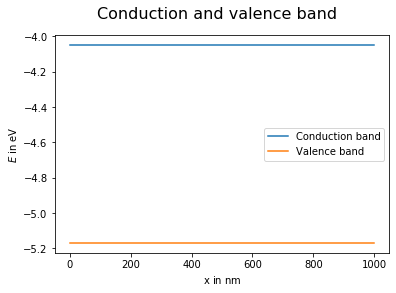

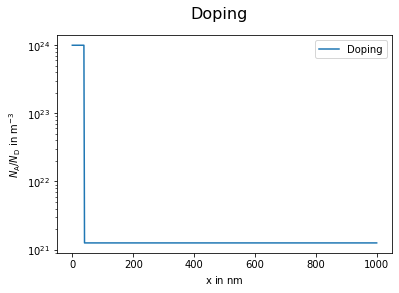

In [3]:
#
# Band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.Chi, label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.Chi-parameters.Eg, label='Valence band')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$E$ in $\mathrm{eV}$")

axis.legend()
plt.show()

#
# Doping level
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, np.abs(parameters.C), label='Doping')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$N_\mathrm{A} / N_\mathrm{D}$ in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()


## Solving without biasing
Now, let's apply a voltage of $0\,\mathrm{mV}$!.

In [4]:
solver.solve_from_doping()

solver.solve_no_bias()
bias_point = 0.0

solver.solve_bias(bias_point,0)

/home/pabele/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


True

## Plot the potential

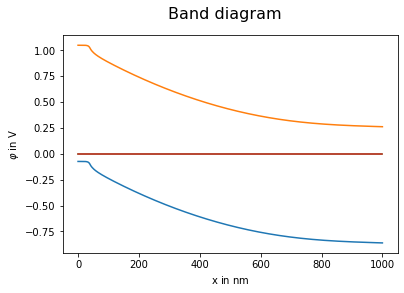

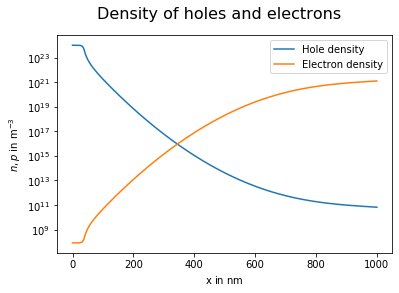

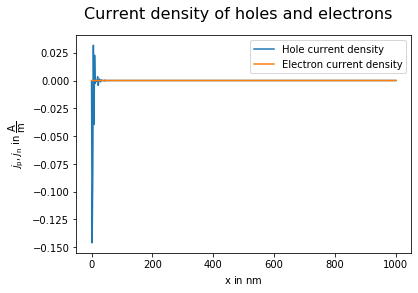

In [5]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

plt.show()

#
# Electron and hole density
#
calc_p_density()
calc_n_density()
p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x * 1E9, n, label='Electron density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$n,p$ in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()


# Electron and hole current density 
j_p =     hole_current_density()
j_n = electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}$ in $\mathrm{\dfrac{A}{m}}$")

axis.legend()
plt.show()

## Simulation with illumination
Now we illuminate the solar cell and simulate the short circuit current density.<br>
We assume a powerdensity of $1\,\mathrm{\dfrac{kW}{m^3}}$,
an absorption coefficient for silicon of $\alpha_\mathrm{Si} = 2.0\cdot 10^{6}\,\mathrm{m^{-1}}$, and
a light efficiency of $\eta = 0.6$. <br>
For the simulation to converge, the illumination must be ramped up, this takes some time.<br>


In [6]:
# For the simulatoin the illumination starts
# 10nm after and stops 10nm before the contacts.
x1 = 10E-9
x2 = 990E-9


bias_point = 0.0

eta = 0.6

I0 = 1E3

alpha = 2E6

dI0 = alpha*I0*eta

steps = 25 #default 23

for i in range(steps):

    print("Step:", i,
          "Generation rate at the surface",
          dI0/(2**steps) * 2**(i+1) /(parameters.q * Eg))

    parameters.generation = np.where((parameters.pos_x  > x1) & (parameters.pos_x < x2),
                                     dI0/(2**steps) * 2**(i+1) * np.exp(-parameters.pos_x*alpha) /(parameters.q * Eg),
                                     0)

    solver.solve_bias(-bias_point,0)
    
    j = np.mean(hole_current_density() + electron_current_density())
    
    print("\t Current density:", j)
    

Step: 0 Generation rate at the surface 3.991382462637765e+20
	 Current density: -1.4109917499924985e-05
Step: 1 Generation rate at the surface 7.98276492527553e+20
	 Current density: -0.00022141899887859166
Step: 2 Generation rate at the surface 1.596552985055106e+21
	 Current density: -0.00020227840697117957
Step: 3 Generation rate at the surface 3.193105970110212e+21
	 Current density: -5.9417539155424764e-05
Step: 4 Generation rate at the surface 6.386211940220424e+21
	 Current density: -0.0004288641718612998
Step: 5 Generation rate at the surface 1.2772423880440847e+22
	 Current density: -0.0011920096673411202
Step: 6 Generation rate at the surface 2.5544847760881695e+22
	 Current density: -0.0013148940014746358
Step: 7 Generation rate at the surface 5.108969552176339e+22
	 Current density: -0.0033566993546124795
Step: 8 Generation rate at the surface 1.0217939104352678e+23
	 Current density: -0.006665621265976527
Step: 9 Generation rate at the surface 2.0435878208705356e+23
	 Curr

## Plot the parameters with illumination
* generation rate,
* hole and electron density, and
* hole and electron current density.

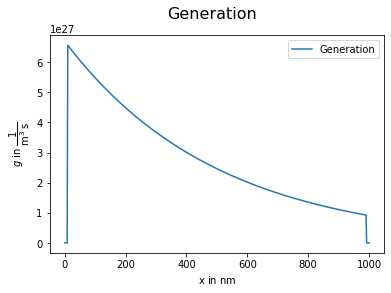

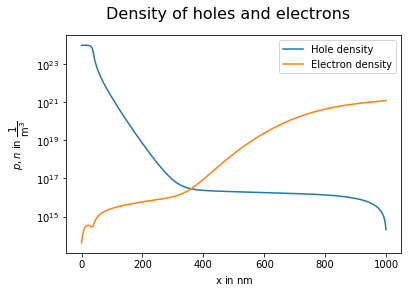

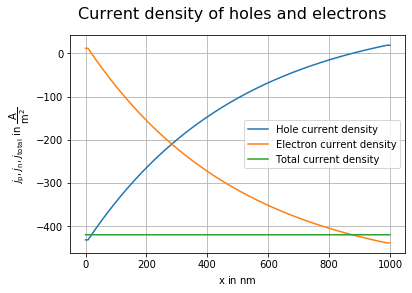

In [7]:
#
# Plot generation rate
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Generation", fontsize=16)

axis.plot(parameters.pos_x * 1E9, parameters.generation, label='Generation')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$g$ in $\mathrm{\dfrac{1}{m^3\, s}}$")

axis.legend()
plt.show()

#
# PLot hole and electron density
#
calc_p_density()
calc_n_density()

p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x * 1E9, n, label='Electron density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$p, n$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.legend()
plt.show()

#
# Plot hole and electron current density 
#
j_p =     hole_current_density()
j_n =     electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')
axis.plot(parameters.pos_x * 1E9, j_n+j_p, label='Total current density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}, j_\mathrm{total}$ in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
axis.grid()
plt.show()

## Voltage sweep
Now, the voltage is swept to get the characteristics of the solar cell for illumination

In [8]:
u_start = 0.0
u_stop  = 0.50
u_step  = 0.025

voltage = []
current_density = []

bias_points = np.linspace(u_start, u_stop, int((u_stop-u_start)/u_step) + 2)
for bias_point in bias_points:

    solver.solve_bias(bias_point,0)   
    
    j = np.mean(hole_current_density() + electron_current_density())
    voltage.append(bias_point)
    current_density.append(j)
    print(bias_point, ",", j)
  

0.0 , -420.6257286416949
0.023809523809523808 , -419.4984953261466
0.047619047619047616 , -418.304544208898
0.07142857142857142 , -417.03918550329143
0.09523809523809523 , -415.698966170602
0.11904761904761904 , -414.27699688147965
0.14285714285714285 , -412.76518131515496
0.16666666666666666 , -411.15103947441764
0.19047619047619047 , -409.4123762307048
0.21428571428571427 , -407.5063039957025
0.23809523809523808 , -405.34098907199524
0.26190476190476186 , -402.71189781772114
0.2857142857142857 , -399.1466725356671
0.30952380952380953 , -393.54188404291256
0.3333333333333333 , -383.2938891828637
0.3571428571428571 , -362.2400261217179
0.38095238095238093 , -315.7764987652326
0.40476190476190477 , -209.30334656391636
0.42857142857142855 , 39.006430152204686
0.45238095238095233 , 621.9335969306519
0.47619047619047616 , 1990.582013287097
0.5 , 5187.783621550221


## Plot solar cell characteristics
* the current density and 
* the power density.

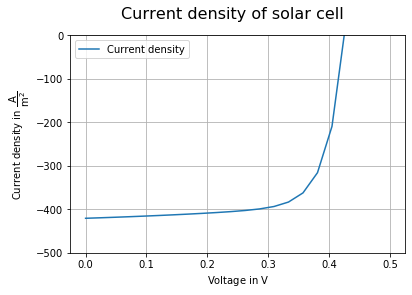

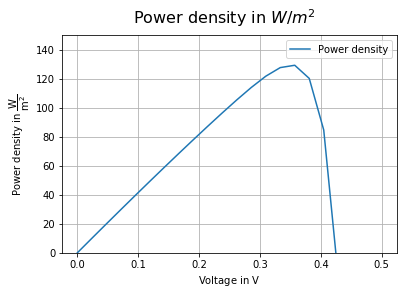

In [9]:
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of solar cell", fontsize=16)

axis.plot(voltage, current_density, label='Current density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(-500,0)
plt.show()


# Power density
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Power density in $W/m^2$", fontsize=16)

axis.plot(voltage, -np.array(current_density)*np.array(voltage), label='Power density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Power density in $\mathrm{\dfrac{W}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(0,150)
plt.show()

In [10]:
np.save("current_density_0125E22.data",np.array(current_density))

In [11]:
cd_8E22 = np.load("current_density_8E22.data.npy")
cd_4E22 = np.load("current_density_4E22.data.npy")
cd_1E22 = np.load("current_density_1E22.data.npy")
cd_025E22 = np.load("current_density_025E22.data.npy")
cd_0125E22 = np.load("current_density_0125E22.data.npy")


In [15]:
cd_4E22

array([-337.0695434 , -336.50010645, -335.91985236, -335.32845318,
       -334.72492906, -334.10876206, -333.47996266, -332.83627647,
       -332.17695099, -331.49893985, -330.79834554, -330.06376912,
       -329.26995911, -328.35560829, -327.16793708, -325.32983798,
       -321.89713049, -314.51569072, -297.30309903, -255.56033004,
       -152.55505119,  103.47542818])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


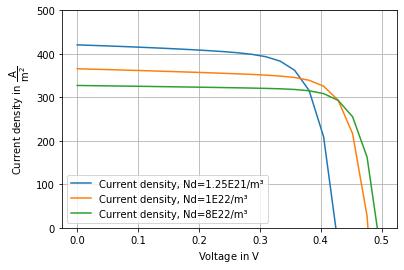

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


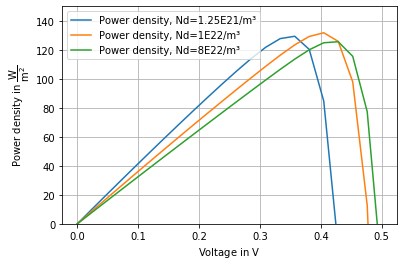

In [20]:
fig, axis = plt.subplots(1,1, sharey=True)
#fig.suptitle("Current density of solar cell", fontsize=16)

axis.plot(voltage, -cd_0125E22, label='Current density, Nd=1.25E21/m³')
axis.plot(voltage, -cd_1E22, label='Current density, Nd=1E22/m³')
axis.plot(voltage, -cd_8E22, label='Current density, Nd=8E22/m³')



axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(00,500)
plt.savefig("Output_Characteristsics.eps")
plt.show()


# Power density
fig, axis = plt.subplots(1,1, sharey=True)
#fig.suptitle("Power density in $W/m^2$", fontsize=16)

axis.plot(voltage, -cd_0125E22*np.array(voltage), label='Power density, Nd=1.25E21/m³')
axis.plot(voltage, -cd_1E22*np.array(voltage), label='Power density, Nd=1E22/m³')
axis.plot(voltage, -cd_8E22*np.array(voltage), label='Power density, Nd=8E22/m³')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Power density in $\mathrm{\dfrac{W}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(0,150)
plt.savefig("Power_Density.eps")
plt.show()